<a href="https://colab.research.google.com/github/CristinaMarsh/Reproduce/blob/main/TimeSeries/Ensemble_Conformalized_Quantile_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/FilippoMB/Ensemble-Conformalized-Quantile-Regression.git

Cloning into 'Ensemble-Conformalized-Quantile-Regression'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 70 (delta 31), reused 42 (delta 13), pack-reused 0
Unpacking objects: 100% (70/70), done.


In [2]:
%cd Ensemble-Conformalized-Quantile-Regression/

/content/Ensemble-Conformalized-Quantile-Regression


In [4]:
import tensorflow as tf

# Ref: https://www.tensorflow.org/guide/gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
from models import regression_model
import data_preprocessing
from conformal_prediction import EnCQR
import utils
import data_loaders

In [6]:
target_idx = [0]            # target variables to predict
B = 3                       # number of ensembles
alpha = 0.1                 # confidence level            
quantiles = [alpha/2,       # quantiles to predict
             0.5,
             1-(alpha/2)] 

# rf only
n_trees = 20                # number of trees in each rf model

# lstm and tcn only
regression = 'quantile'     # options: {'quantile', 'linear'}. If 'linear', just set one quantile
l2_lambda = 1e-4            # weight of l2 regularization in the lstm and tcn models
batch_size = 16             # size of batches using to train the lstm and tcn models

# lstm only
units = 128                 # number of units in each lstm layer
n_layers = 3                # number of lstm layers in the model

# tcn only
dilations = [1,2,4,8]       # dilation rate of the Conv1D layers
n_filters = 128             # filters in each Conv1D layer 
kernel_size = 7             # kernel size in each ConvID layer

# Store the configuration in a dictionary
P = {'B':B, 'alpha':alpha, 'quantiles':quantiles,
     'n_trees':n_trees,  
     'regression':regression,'l2':l2_lambda, 'batch_size':batch_size,
     'units':units,'n_layers':n_layers,
     'dilations':dilations, 'n_filters':n_filters, 'kernel_size':kernel_size}

In [7]:
train_df, val_df, test_df = data_loaders.get_solar_data()

train_df.head()

,MWH,Temperature_F,Humidity_percent,Sunhour,CloudCover_percent,uvIndex
hour_list,,,,,,
2017-01-01 00:00:00,0.0,58,95,8.7,11,1
2017-01-01 01:00:00,0.0,57,95,8.7,11,1
2017-01-01 02:00:00,0.0,56,95,8.7,11,1
2017-01-01 03:00:00,0.0,56,95,8.7,12,1
2017-01-01 04:00:00,0.0,55,89,8.7,13,1


## Data preprocessing

The `data_windowing()` function transforms each DataFrame into 3-dimensional arrays of shape `[number of samples, time steps, number of variables ]`. The input data, X, might have a different number of time steps and a different number of variables than the output data, Y. In this case, we want to predict the energy production for the next day given the measurements of the past week. Therefore, the second dimension of X is time_steps_in=168 (hours in the past week) and the second dimension of Y is time_steps_out=24 (hours of the next day). The input variables are the historical energy production plus 5 exogenous variables, so the last dimension of X is n_vars=6. Since we want to predict the future energy production, we specify the target variable to predict: label_columns=['MWH']. Note that in Y n_vars=1.

data_windowing() also rescales each variable in [0,1] and return the scaler, which is used to invert the transformation.

In addition, it also splits training data in B disjoint sets, used to train the ensemble model. In this case, B=3.

In [8]:
train_data, val_x, val_y, test_x, test_y, Scaler = data_preprocessing.data_windowing(df=train_df, 
                                                                                     val_data=val_df,
                                                                                     test_data=test_df,
                                                                                     B=3, 
                                                                                     time_steps_in=168, 
                                                                                     time_steps_out=24, 
                                                                                     label_columns=['MWH'])

print("-- Training data --")
for i in range(len(train_data)):
    print(f"Set {i} - x: {train_data[i][0].shape}, y: {train_data[i][1].shape}")
print("-- Validation data --")
print(f"x: {val_x.shape}, y: {val_y.shape}")
print("-- Test data --")
print(f"x: {test_x.shape}, y: {test_y.shape}")

# Update configuration dict
P['time_steps_in'] = test_x.shape[1]
P['n_vars'] = test_x.shape[2] 
P['time_steps_out'] = test_y.shape[1]

-- Training data --
Set 0 - x: (112, 168, 6), y: (112, 24)
Set 1 - x: (112, 168, 6), y: (112, 24)
Set 2 - x: (112, 168, 6), y: (112, 24)
-- Validation data --
x: (357, 168, 6), y: (357, 24)
-- Test data --
x: (357, 168, 6), y: (357, 24)


<Figure size 432x288 with 0 Axes>

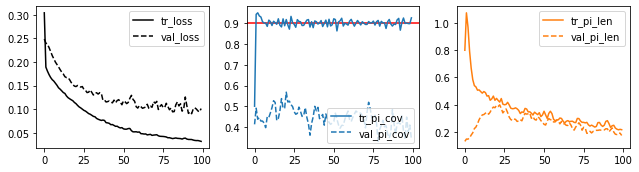

<Figure size 432x288 with 0 Axes>

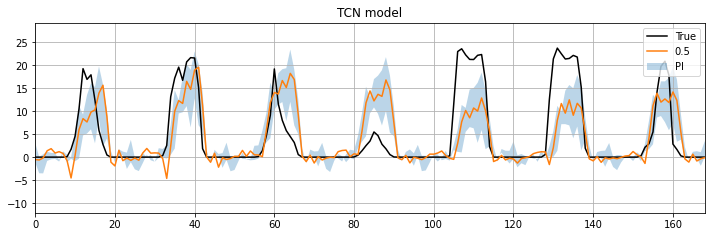

In [9]:
P['model_type'] = 'tcn' 

# Train 
model = regression_model(P)
hist = model.fit(train_data[0][0], train_data[0][1], val_x, val_y)
utils.plot_history(hist)

# Test
PI = model.transform(test_x)
utils.plot_PIs(test_y, PI[:,:,1],
                PI[:,:,0], PI[:,:,2],
                x_lims=[0,168], scaler=Scaler, title='TCN model')

<Figure size 432x288 with 0 Axes>

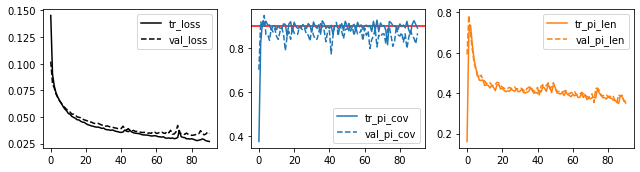

<Figure size 432x288 with 0 Axes>

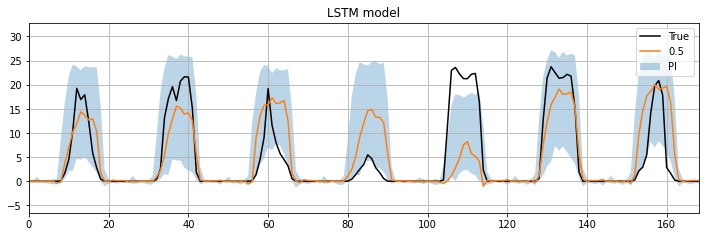

In [10]:
P['model_type'] = 'lstm'

# Train
model = regression_model(P)
hist = model.fit(train_data[0][0], train_data[0][1], val_x, val_y)
utils.plot_history(hist)

# Test
PI = model.transform(test_x)
utils.plot_PIs(test_y, PI[:,:,1],
                PI[:,:,0], PI[:,:,2],
                x_lims=[0,168], scaler=Scaler, title='LSTM model')

<Figure size 432x288 with 0 Axes>

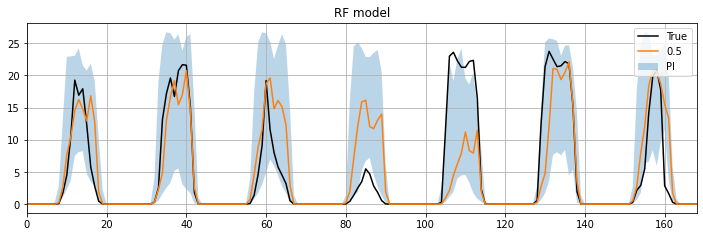

In [12]:
# Train
P['model_type'] = 'rf'
model = regression_model(P)
model.fit(train_data[0][0], train_data[0][1])

# Test
PI = model.transform(test_x)
utils.plot_PIs(test_y, PI[:,:,1],
                PI[:,:,0], PI[:,:,2],
                x_lims=[0,168], scaler=Scaler, title='RF model')

<Figure size 432x288 with 0 Axes>

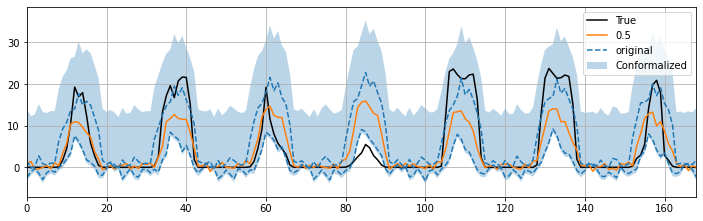

Before conformalization:
PI coverage: 55.0%, PI avg. length: 0.233, CWC: 0.020
After conformalization:
PI coverage: 92.8%, PI avg. length: 0.678, CWC: 0.315


In [13]:
P['model_type'] = 'tcn'

# compute the conformalized PI with EnCQR
PI, conf_PI = EnCQR(train_data, val_x, val_y, test_x, test_y, P)

# Plot original and conformalized PI
utils.plot_PIs(test_y, PI[:,:,1],
               PI[:,:,0], PI[:,:,2],
               conf_PI[:,:,0], conf_PI[:,:,2],
               x_lims=[0,168], scaler=Scaler)

# Compute PI coverage and length before and after conformalization
print("Before conformalization:")
utils.compute_coverage_len(test_y.flatten(), PI[:,:,0].flatten(), PI[:,:,2].flatten(), verbose=True)
print("After conformalization:")
utils.compute_coverage_len(test_y.flatten(), conf_PI[:,:,0].flatten(), conf_PI[:,:,2].flatten(), verbose=True)